# Load dataset From Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/Dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/Dataset/51/image_01381.jpg  
  inflating: /content/Dataset/51/image_01382.jpg  
  inflating: /content/Dataset/51/image_01383.jpg  
  inflating: /content/Dataset/51/image_01384.jpg  
  inflating: /content/Dataset/51/image_01385.jpg  
  inflating: /content/Dataset/51/image_01386.jpg  
  inflating: /content/Dataset/51/image_01387.jpg  
  inflating: /content/Dataset/51/image_01388.jpg  
  inflating: /content/Dataset/51/image_01389.jpg  
  inflating: /content/Dataset/51/image_01390.jpg  
  inflating: /content/Dataset/51/image_01391.jpg  
  inflating: /content/Dataset/51/image_01392.jpg  
  inflating: /content/Dataset/51/image_01393.jpg  
  inflating: /content/Dataset/51/image_01394.jpg  
  inflating: /content/Dataset/51/image_01395.jpg  
  inflating: /content/Dataset/51/image_01396.jpg  
  inflating: /content/Dataset/51/image_01397.jpg  
  inflating: /content/Dataset/51/image_01398.jpg  
  inflating: /content/Dataset/5

In [4]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [5]:
root_folder = '/content/Dataset'
seed = 1234
torch.manual_seed(seed)

# Dataset Loader

## Dataset Defenition

In [6]:
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_folders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]
        self.image_paths = []
        self.labels = []

        for label, class_folder in enumerate(self.class_folders):
            img_paths = glob.glob(os.path.join(root_dir, class_folder, '*.jpg'))
            self.image_paths.extend(img_paths)
            self.labels.extend([label] * len(img_paths))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
def stratified_split(dataset, test_size=0.1, val_size=0.2, random_state=seed):
    indices = list(range(len(dataset)))
    labels = dataset.labels

    # Split indices for train+val and test sets
    train_val_indices, test_indices = train_test_split(
        indices, test_size=test_size, stratify=labels, random_state=random_state
    )

    # Split indices for train and validation sets
    train_indices, val_indices = train_test_split(
        train_val_indices, test_size=val_size, stratify=[labels[i] for i in train_val_indices], random_state=random_state
    )

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    return train_dataset, val_dataset, test_dataset

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
])

# Load images from the folder using custom dataset
dataset = ImageFolderDataset( root_dir=root_folder,
                             transform=transform)

## split data to Train, Validation and Test sets

In [9]:
train_dataset, val_dataset, test_dataset = stratified_split(dataset)

In [ ]:
# Print the number of samples in each set
print(f'Training set: {len(train_dataset)} samples')
print(f'Validation set: {len(val_dataset)} samples')
print(f'Test set: {len(test_dataset)} samples')

Training set: 5896 samples
Validation set: 1474 samples
Test set: 819 samples


### Split distribution

In [ ]:
save_plots_path = '/content/training'

if not os.path.exists(save_plots_path):
    os.mkdir(save_plots_path)


def plot_dataset_distribution(dataset,title):
    plt.figure(figsize=(14,7))
    plt.hist(dataset.labels, bins=[x for x in range(1,103)], density=True)
    plt.title(title)
    plt.xlabel('Category')
    plt.ylabel('Category Density')
    path = os.path.join(save_plots_path, f'{title}.jpg')
    plt.savefig(path, bbox_inches='tight', dpi=300)
    plt.show()

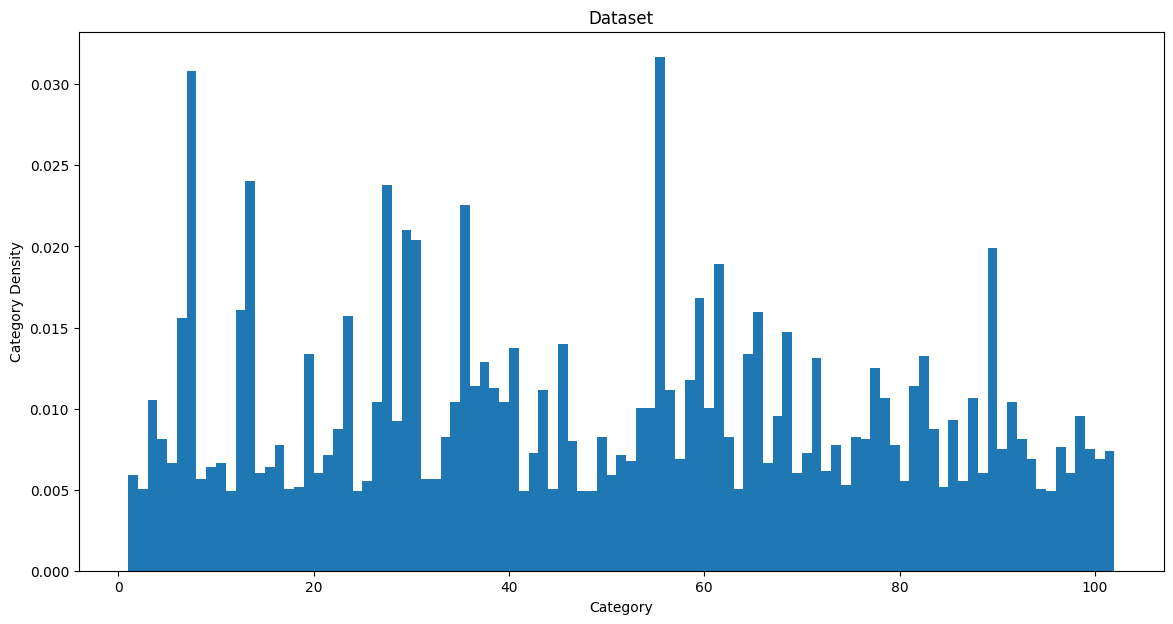

In [ ]:
plot_dataset_distribution(dataset,'Dataset')

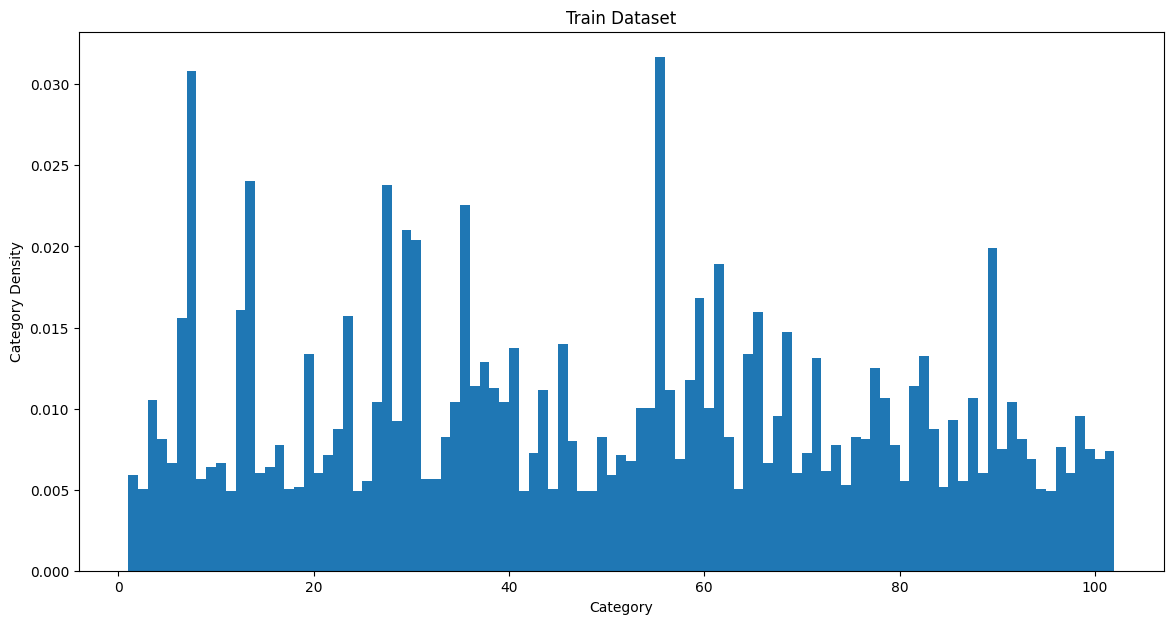

In [ ]:
plot_dataset_distribution(train_dataset.dataset,'Train Dataset')

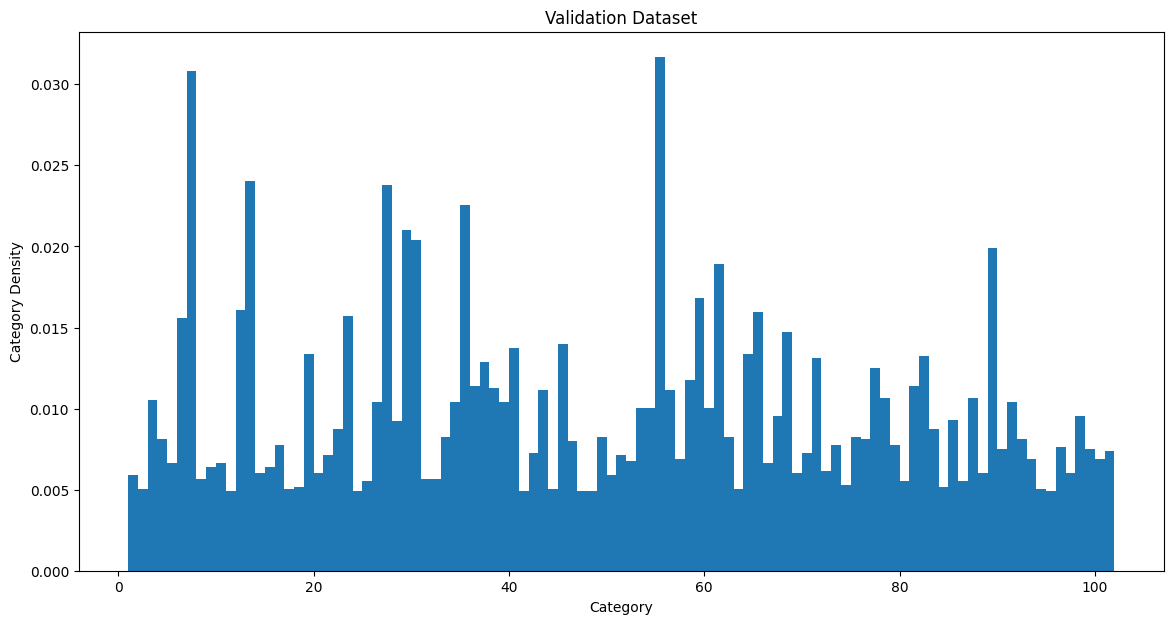

In [ ]:
plot_dataset_distribution(val_dataset.dataset,'Validation Dataset')

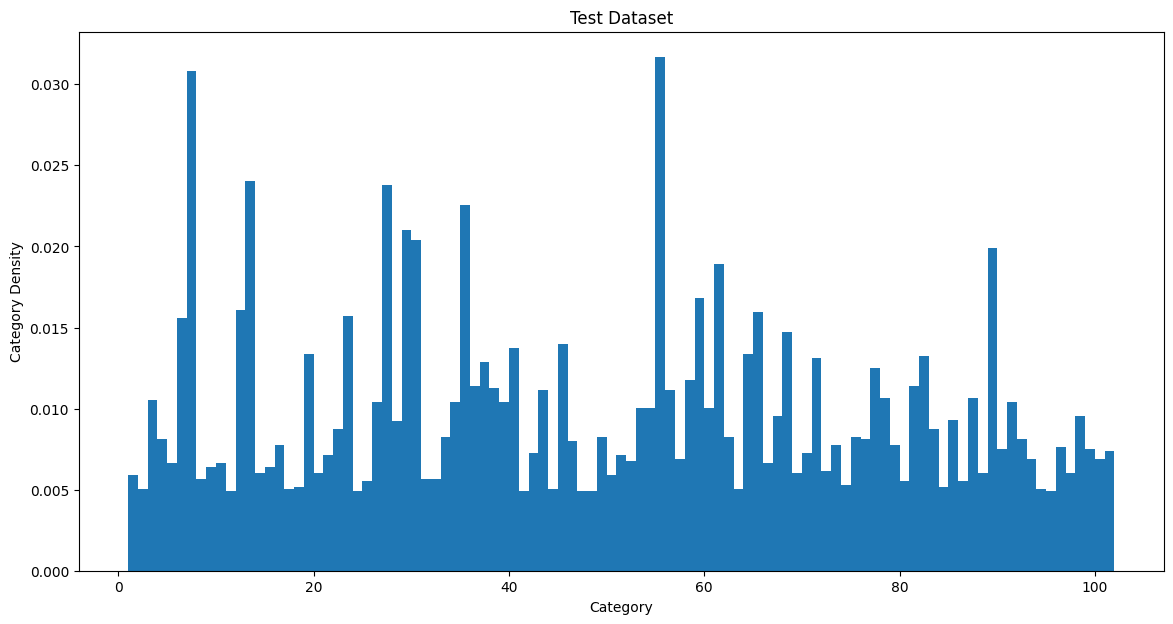

In [ ]:
plot_dataset_distribution(test_dataset.dataset,'Test Dataset')

## Biuld DataLoaders with Upsampling

In [10]:
labales_list = [dataset.labels[x] for x in train_dataset.indices]
class_counts = np.bincount(labales_list)
class_weights = 1. / class_counts
sample_weights = class_weights[labales_list]
train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights)*2, replacement=True)
train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)

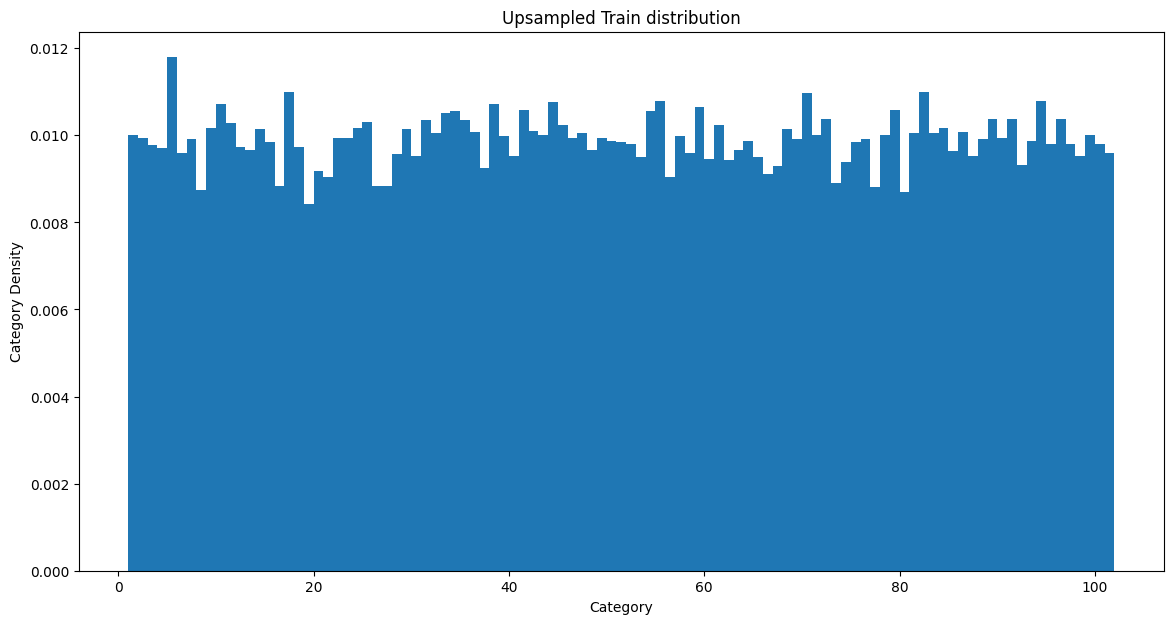

In [ ]:
def collect_labels(dataloader):
    all_labels = []
    for _, labels in dataloader:
        all_labels.extend(labels.numpy())
    return np.array(all_labels)

train_labels_upsampled = collect_labels(train_loader)
plt.figure(figsize=(14,7))
plt.hist(train_labels_upsampled, bins=[x for x in range(1,103)], density=True)
plt.title('Upsampled Train distribution')
plt.xlabel('Category')
plt.ylabel('Category Density')
plt.show()

In [11]:
labales_list = [dataset.labels[x] for x in val_dataset.indices]
class_counts = np.bincount(labales_list)
class_weights = 1. / class_counts
sample_weights = class_weights[labales_list]
val_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights)*2, replacement=True)
val_loader = DataLoader(val_dataset, batch_size=32, sampler=val_sampler)

In [12]:
labales_list = [dataset.labels[x] for x in test_dataset.indices]
class_counts = np.bincount(labales_list)
class_weights = 1. / class_counts
sample_weights = class_weights[labales_list]
test_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights)*2, replacement=True)
test_loader = DataLoader(test_dataset, batch_size=32, sampler=test_sampler)

In [ ]:
# Print the number of samples in each set
print(f'Training set: {len(train_loader.dataset)} samples')
print(f'Validation set: {len(val_loader.dataset)} samples')
print(f'Test set: {len(test_loader.dataset)} samples')

Training set: 5896 samples
Validation set: 1474 samples
Test set: 819 samples


# Model Training

In [13]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torchvision import models

In [14]:
features_dim = 10 # dimension of representation

## define CenterLoss And Model Architecture

In [15]:
class CenteredLoss(nn.Module):
    def __init__(self, num_classes, feature_dim):
        super(CenteredLoss, self).__init__()
        self.num_classes = num_classes
        self.feature_dim = feature_dim
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Initialize the centers for each class
        self.centers = nn.Parameter(torch.randn(num_classes, feature_dim).to(self.device))

        # Initialize containers to store features and labels
        self.features_list = []
        self.labels_list = []

    def forward(self, features, labels):
        # Save features and labels for center updating
        self.features_list.append(features.detach().cpu())
        self.labels_list.append(labels.detach().cpu())

        # Get the centers of the corresponding labels
        centers_batch = self.centers.index_select(0, labels)

        # Calculate the centered loss
        loss = F.mse_loss(features, centers_batch)

        return loss

    def update_centers(self):
        # Concatenate all saved features and labels
        features = torch.cat(self.features_list, dim=0)
        labels = torch.cat(self.labels_list, dim=0)

        # Reset lists for the next epoch
        self.features_list = []
        self.labels_list = []

        # Calculate new centers
        new_centers = torch.zeros_like(self.centers)
        for i in range(self.num_classes):
            mask = (labels == i)
            if mask.sum() > 0:
                new_centers[i] = features[mask].mean(dim=0)

        self.centers.data = new_centers.to(self.device)


class CombinedModel(nn.Module):
    def __init__(self, num_classes, alpha=0.5):
        super(CombinedModel, self).__init__()
        self.alpha = alpha
        self.base_model = models.resnet18(pretrained=True)

        for name, param in self.base_model.named_parameters():
            if 'layer1' in name or 'layer2' in name:
                param.requires_grad = False # freeze deep layers

        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, features_dim),
        )

        self.classifier = nn.Linear(features_dim, num_classes)
        self.centered_loss_fn = CenteredLoss(num_classes, features_dim)

    def forward(self, x):
        features = self.base_model(x)
        logits = self.classifier(features)
        return features, logits

    def compute_loss(self, features, logits, labels):
        softmax_loss = nn.CrossEntropyLoss()(logits, labels)
        centered_loss = self.centered_loss_fn(features, labels)
        total_loss = softmax_loss + self.alpha * centered_loss
        return total_loss, softmax_loss, centered_loss


## definition of Training And Evaluation

In [16]:
def train(model, train_dataloader, val_dataloader, num_epochs, optimizer, patience):
    best_val_loss = np.inf
    early_stop_counter = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            features, logits = model(images)
            total_loss, _, _ = model.compute_loss(features, logits, labels)
            total_loss.backward()
            optimizer.step()
            train_loss += total_loss.item()

        val_loss = evaluate(model, val_dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_dataloader)}, Val Loss: {val_loss}')

        model.centered_loss_fn.update_centers()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), '/content/drive/MyDrive/best_model_Augmented.pth')
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print('Early stopping')
                break

def evaluate(model, dataloader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            features, logits = model(images)
            total_loss, softmax_loss, centered_loss = model.compute_loss(features, logits, labels)
            # val_loss += softmax_loss.item()
            val_loss += total_loss.item()
    return val_loss / len(dataloader)


## Train

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CombinedModel(num_classes=102, alpha=0.1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 129MB/s]


In [18]:
num_epochs = 10
patience = 5
train(model, train_loader, val_loader, num_epochs, optimizer, patience=patience)

Epoch [1/10], Train Loss: 4.324787038081401, Val Loss: 3.850708107794485
Epoch [2/10], Train Loss: 2.984285663914036, Val Loss: 2.8428619907748316
Epoch [3/10], Train Loss: 2.0182562434995495, Val Loss: 3.8486185458398636
Epoch [4/10], Train Loss: 1.253940489485457, Val Loss: 1.7308079625970574
Epoch [5/10], Train Loss: 0.7358472853093534, Val Loss: 2.4527376595363823
Epoch [6/10], Train Loss: 0.3871783705176534, Val Loss: 1.4241070452556814
Epoch [7/10], Train Loss: 0.20135503350882916, Val Loss: 1.5400997015737719
Epoch [8/10], Train Loss: 0.12002784279552665, Val Loss: 1.3418752269078327
Epoch [9/10], Train Loss: 0.07303372357745429, Val Loss: 1.332056959470113
Epoch [10/10], Train Loss: 0.06443046675743283, Val Loss: 1.1945174355660715


In [ ]:
!cp /content/drive/MyDrive/best_model_Augmented.pth /content/best_model.pth

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [19]:
num_epochs = 10
patience = 5
train(model, train_loader, val_loader, num_epochs, optimizer, patience=patience)

Epoch [1/10], Train Loss: 0.044625109927477064, Val Loss: 1.1798265063634483
Epoch [2/10], Train Loss: 0.03557626438906064, Val Loss: 1.1516736136969699
Epoch [3/10], Train Loss: 0.02924227737695784, Val Loss: 1.0748720742681974
Epoch [4/10], Train Loss: 0.026961176701494165, Val Loss: 1.0797935121802873
Epoch [5/10], Train Loss: 0.02783445838738132, Val Loss: 1.0808970415464012
Epoch [6/10], Train Loss: 0.022178296372294425, Val Loss: 1.1068893328148832
Epoch [7/10], Train Loss: 0.019863586782200918, Val Loss: 1.0727037483005113
Epoch [8/10], Train Loss: 0.01997136536079484, Val Loss: 1.1773188607667082
Epoch [9/10], Train Loss: 0.01788131455714638, Val Loss: 1.1615456124787689
Epoch [10/10], Train Loss: 0.018290864530246, Val Loss: 1.3364089778674546


# Test Model

In [22]:
!cp /content/drive/MyDrive/best_model_Augmented.pth /content/best_model.pth

In [23]:
model = CombinedModel(num_classes=102, alpha=0.5).to(device)
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [24]:
test_loss = evaluate(model, test_loader)
print(f'Test Loss: {test_loss}')

Test Loss: 1.5914711264463572


In [ ]:
torch.cuda.empty_cache()

In [ ]:
# del train_dataset
# del train_loader

# del val_dataset
# del val_loader

# del test_dataset
# del test_loader

## calculate model outputs for Test data

In [25]:
g_ts = []
features = []
predicts = []
with torch.no_grad():
  for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      res , cats = model(images)
      for g_t , predict, cat in zip(labels,res,cats):
          g_ts.append(g_t.item())
          features.append(predict.cpu())
          predicts.append(np.argmax(cat.cpu()))

In [26]:
import pylab
def plot_features(x,y,c):
    plt.figure(figsize=(8,8))
    pylab.scatter(x, y, c=c)
    pylab.show()

## plot Feature Representation for Test data

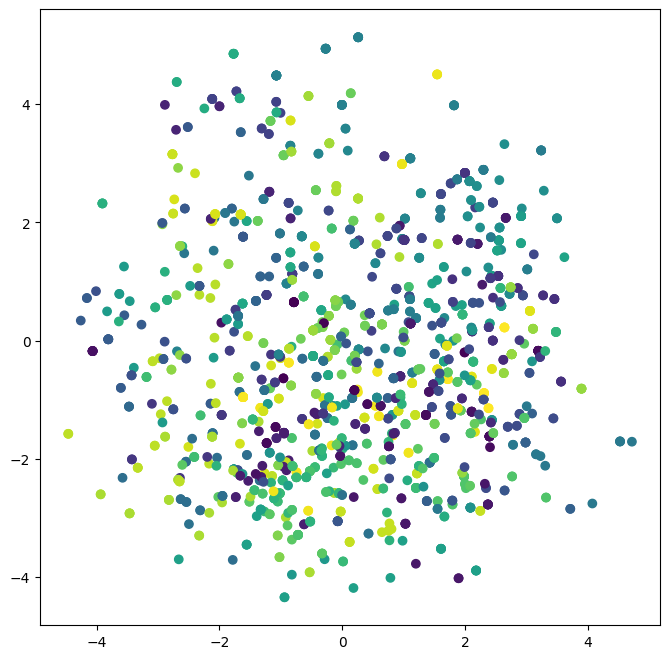

In [27]:
plot_features(np.array(features)[:,0], np.array(features)[:,1], predicts)

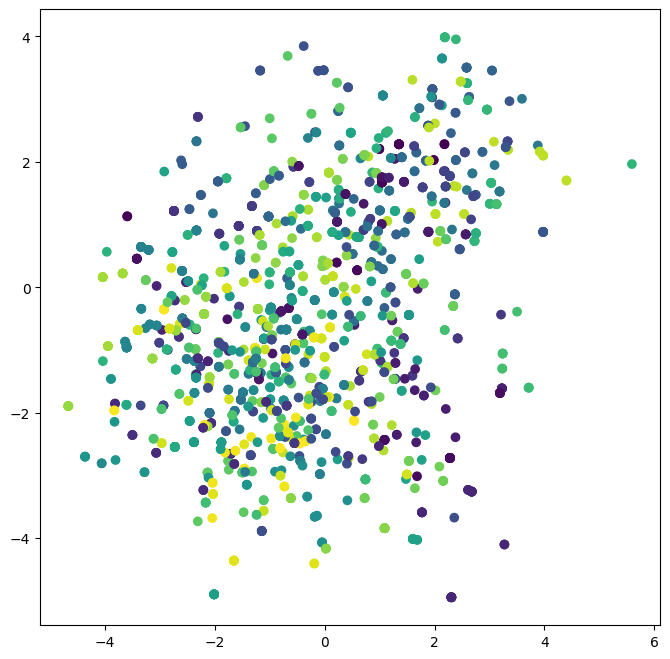

In [28]:
plot_features(np.array(features)[:,2], np.array(features)[:,3], predicts)

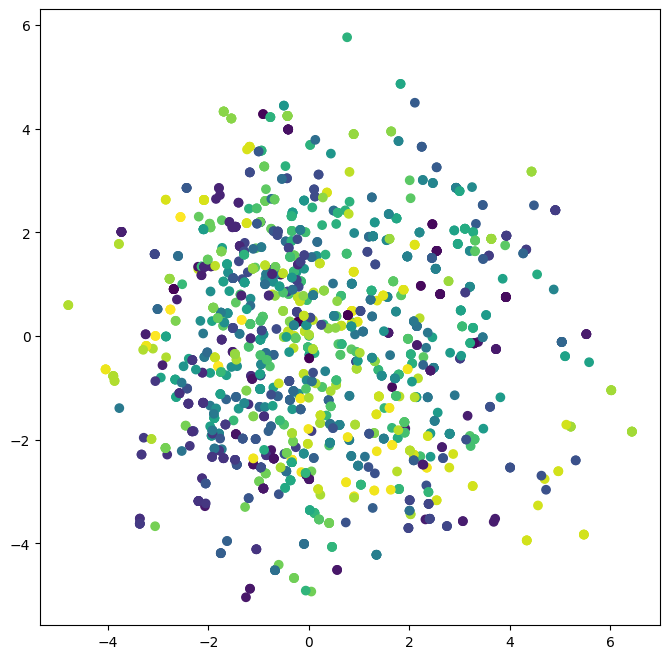

In [29]:
plot_features(np.array(features)[:,4], np.array(features)[:,5], predicts)

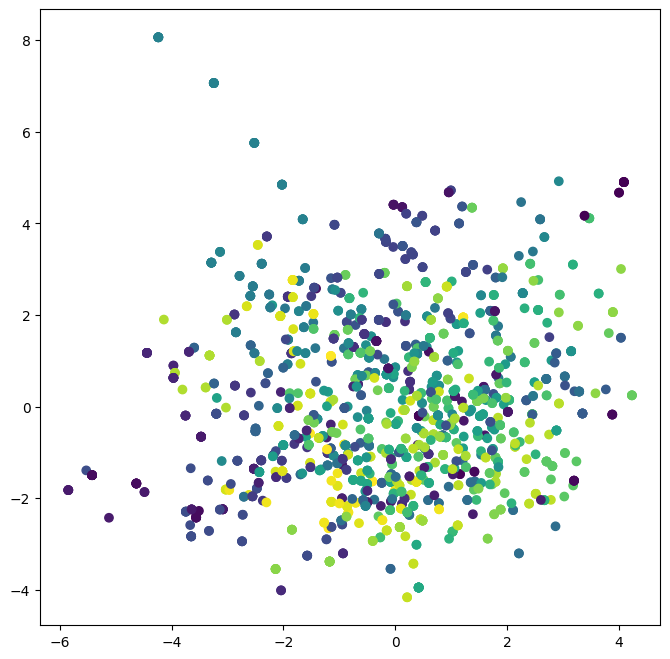

In [30]:
plot_features(np.array(features)[:,6], np.array(features)[:,7], predicts)

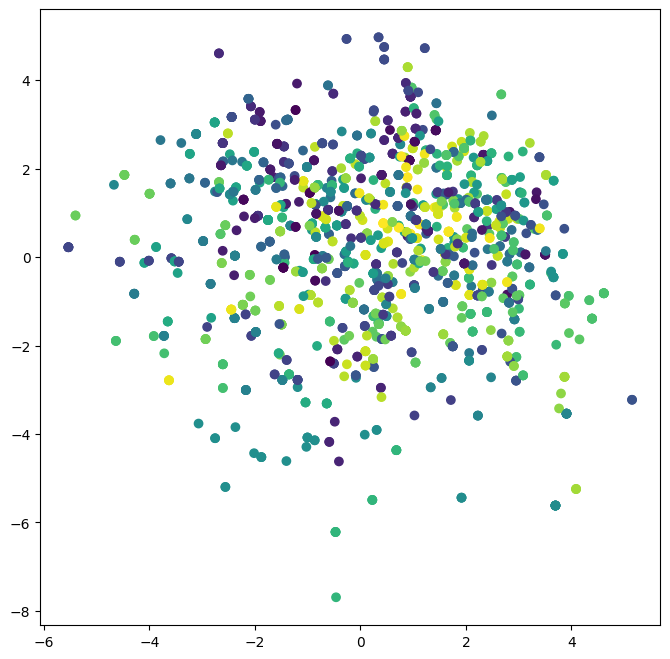

In [31]:
plot_features(np.array(features)[:,8], np.array(features)[:,9], predicts)

## Statistical Metrics

In [32]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [33]:
cm = confusion_matrix(np.array(g_ts), np.array(predicts), labels=[x for x in range(0,102)])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[x for x in range(0,102)])

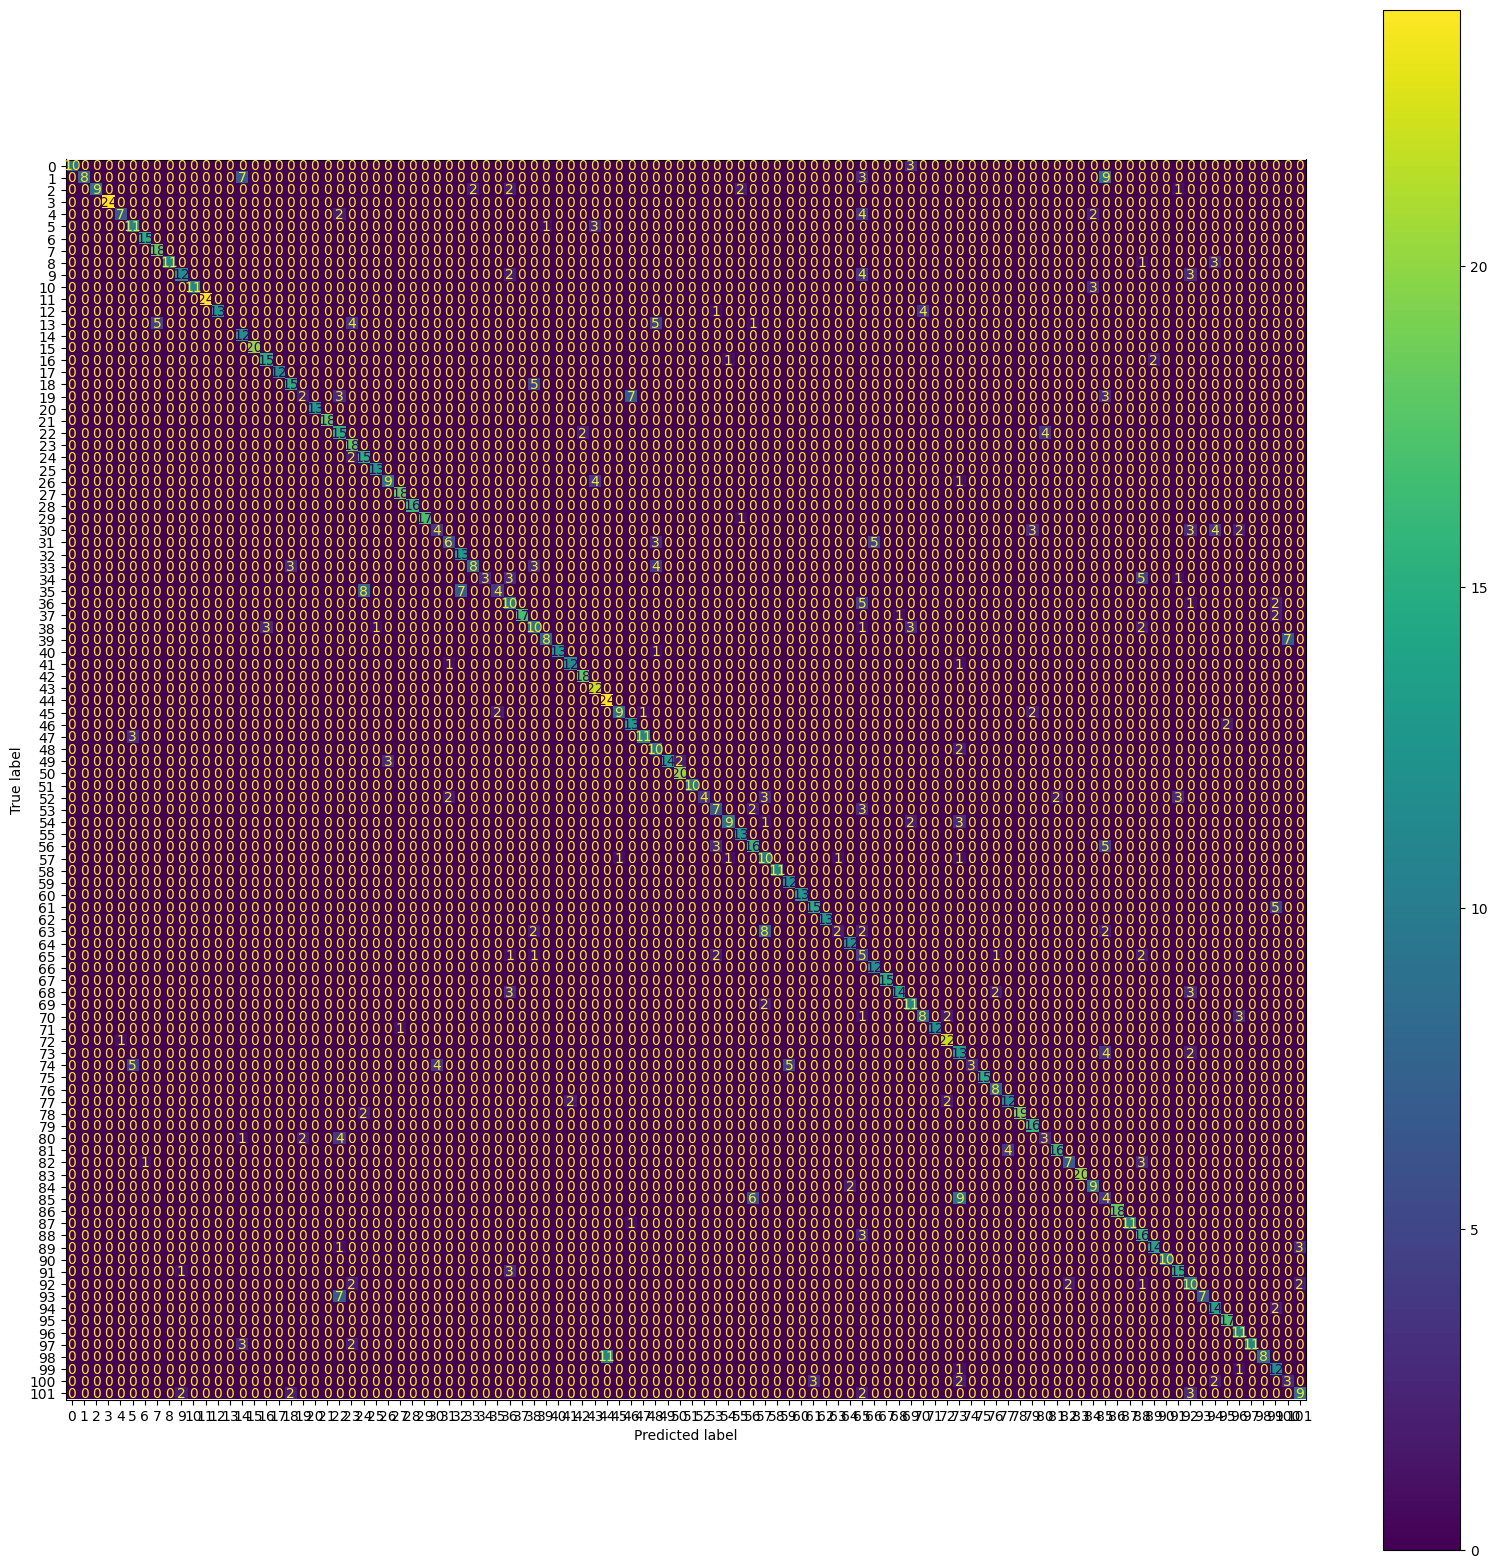

In [34]:
fig, ax = plt.subplots(figsize=(20,20))
disp.plot(ax=ax)
plt.show()

In [35]:
import sklearn.metrics as metrics

In [36]:
metrics.accuracy_score(np.array(g_ts), np.array(predicts))

0.7490842490842491

In [37]:
metrics.precision_score(np.array(g_ts), np.array(predicts),average='micro')

0.7490842490842491

In [38]:
metrics.precision_score(np.array(g_ts), np.array(predicts),average='macro')


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.7826170163493574

In [39]:
metrics.f1_score(np.array(g_ts), np.array(predicts),average='micro')

0.749084249084249

In [40]:
metrics.f1_score(np.array(g_ts), np.array(predicts),average='macro')


0.7386168430791576

In [41]:
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

<ipython-input-41-1d71f19100bf>:11: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
<ipython-input-41-1d71f19100bf>:19: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)


In [42]:
print(f'True  Positive Rate {TPR}')

True  Positive Rate [0.76923077 0.2962963  0.5625     1.         0.46666667 0.73333333
 1.         1.         0.73333333 0.57142857 0.78571429 1.
 0.72222222 0.         1.         1.         0.83333333 1.
 0.75       0.13333333 1.         1.         0.71428571 1.
 0.88235294 1.         0.64285714 1.         1.         0.94444444
 0.25       0.42857143 1.         0.44444444 0.25       0.21052632
 0.55555556 0.85       0.5        0.53333333 0.92857143 0.85714286
 1.         1.         1.         0.64285714 0.86666667 0.78571429
 0.83333333 0.73684211 1.         1.         0.28571429 0.58333333
 0.6        1.         0.66666667 0.71428571 1.         1.
 1.         0.75       1.         0.125      1.         0.41666667
 1.         1.         0.63636364 0.84615385 0.57142857 0.92307692
 0.95652174 0.68421053 0.17647059 1.         1.         0.75
 0.9047619  1.         0.3        0.8        0.63636364 1.
 0.81818182 0.21052632 1.         0.91666667 0.84210526 0.77777778
 1.         0.7894736

In [43]:
print(f'True  Negative Rate {TNR}')

True  Negative Rate [1.         1.         1.         1.         0.99938386 0.99507086
 0.99938386 0.99691358 1.         0.99814471 1.         1.
 1.         1.         0.99323493 1.         0.99814815 1.
 0.99690977 0.99876771 1.         1.         0.9894867  0.99382716
 0.99383097 0.99938462 0.99815271 0.99938272 1.         1.
 0.99753391 0.99815271 0.99569231 0.99876543 1.         0.99876467
 0.99135802 1.         0.99320148 0.99938386 1.         0.99876847
 0.99876543 0.99566832 0.99318463 0.99938424 0.99507086 0.99938424
 0.99200492 1.         0.99876391 1.         1.         0.99630996
 0.99876771 0.99815385 0.99442379 0.99137931 1.         0.99692497
 1.         0.99814586 1.         0.99938348 0.99876999 0.98277983
 0.99692497 1.         0.99938119 0.99507692 0.99753695 1.
 0.99752322 0.9876467  1.         1.         0.99815951 0.99753391
 1.         0.99691739 0.997543   0.99876391 0.99877074 1.
 0.99692686 0.9857937  1.         1.         0.99135269 0.99876543
 1.         0.9

In [44]:
print(f'False Positive Rate {FPR}')

False Positive Rate [0.         0.         0.         0.         0.00061614 0.00492914
 0.00061614 0.00308642 0.         0.00185529 0.         0.
 0.         0.         0.00676507 0.         0.00185185 0.
 0.00309023 0.00123229 0.         0.         0.0105133  0.00617284
 0.00616903 0.00061538 0.00184729 0.00061728 0.         0.
 0.00246609 0.00184729 0.00430769 0.00123457 0.         0.00123533
 0.00864198 0.         0.00679852 0.00061614 0.         0.00123153
 0.00123457 0.00433168 0.00681537 0.00061576 0.00492914 0.00061576
 0.00799508 0.         0.00123609 0.         0.         0.00369004
 0.00123229 0.00184615 0.00557621 0.00862069 0.         0.00307503
 0.         0.00185414 0.         0.00061652 0.00123001 0.01722017
 0.00307503 0.         0.00061881 0.00492308 0.00246305 0.
 0.00247678 0.0123533  0.         0.         0.00184049 0.00246609
 0.         0.00308261 0.002457   0.00123609 0.00122926 0.
 0.00307314 0.0142063  0.         0.         0.00864731 0.00123457
 0.         0.0

In [45]:
print(f'False Negative Rate {FNR}')

False Negative Rate [0.23076923 0.7037037  0.4375     0.         0.53333333 0.26666667
 0.         0.         0.26666667 0.42857143 0.21428571 0.
 0.27777778 1.         0.         0.         0.16666667 0.
 0.25       0.86666667 0.         0.         0.28571429 0.
 0.11764706 0.         0.35714286 0.         0.         0.05555556
 0.75       0.57142857 0.         0.55555556 0.75       0.78947368
 0.44444444 0.15       0.5        0.46666667 0.07142857 0.14285714
 0.         0.         0.         0.35714286 0.13333333 0.21428571
 0.16666667 0.26315789 0.         0.         0.71428571 0.41666667
 0.4        0.         0.33333333 0.28571429 0.         0.
 0.         0.25       0.         0.875      0.         0.58333333
 0.         0.         0.36363636 0.15384615 0.42857143 0.07692308
 0.04347826 0.31578947 0.82352941 0.         0.         0.25
 0.0952381  0.         0.7        0.2        0.36363636 0.
 0.18181818 0.78947368 0.         0.08333333 0.15789474 0.22222222
 0.         0.2105263

# Pair Similarity

In [46]:
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity

In [47]:
# features : n dimension representation of each image
# g_ts : real labels

## Create Pair Samples

In [48]:
features = np.array(features)
g_ts = np.array(g_ts)
g_ts = g_ts.reshape(g_ts.shape[0],1)

In [49]:
features_category = np.concatenate((features, g_ts), axis=-1)

In [50]:
features_category.shape

(1638, 11)

In [51]:
features_category = list(combinations(features_category, 2))

In [52]:
features_category[0]

(array([ 0.91247696, -1.18915975, -0.05828862, -0.81519186,  2.0917747 ,
        -2.29175091, -1.5192771 ,  0.28449026,  1.47348106,  0.97611749,
        30.        ]),
 array([ 1.10045755,  0.49169242,  0.21499851, -1.77036238,  0.80749071,
        -1.15264845, -1.92495513,  0.9246645 ,  0.60957205, -0.56465745,
        43.        ]))

In [53]:
total_pairs = len(features_category)
total_pairs

1340703

## calculate cosine similarity

In [54]:
Y_true = []
cosine_sim = []
for pair in features_category:
    d1,d2 = pair
    Y_true.append(d1[-1] == d2[-1])
    dd1 = np.array(d1[:features_dim]).reshape((1,features_dim))
    dd2 = np.array(d2[:features_dim]).reshape((1,features_dim))
    cosine_sim.append(cosine_similarity(dd1,dd2))

In [55]:
np.count_nonzero(np.array(Y_true) == 1) # Actual True in Pairs

13047

In [56]:
cosine_sim = np.array(cosine_sim).flatten()

In [57]:
false_positive_rate, true_positive_rate, threshold = metrics.roc_curve(np.array(Y_true),np.array(cosine_sim))

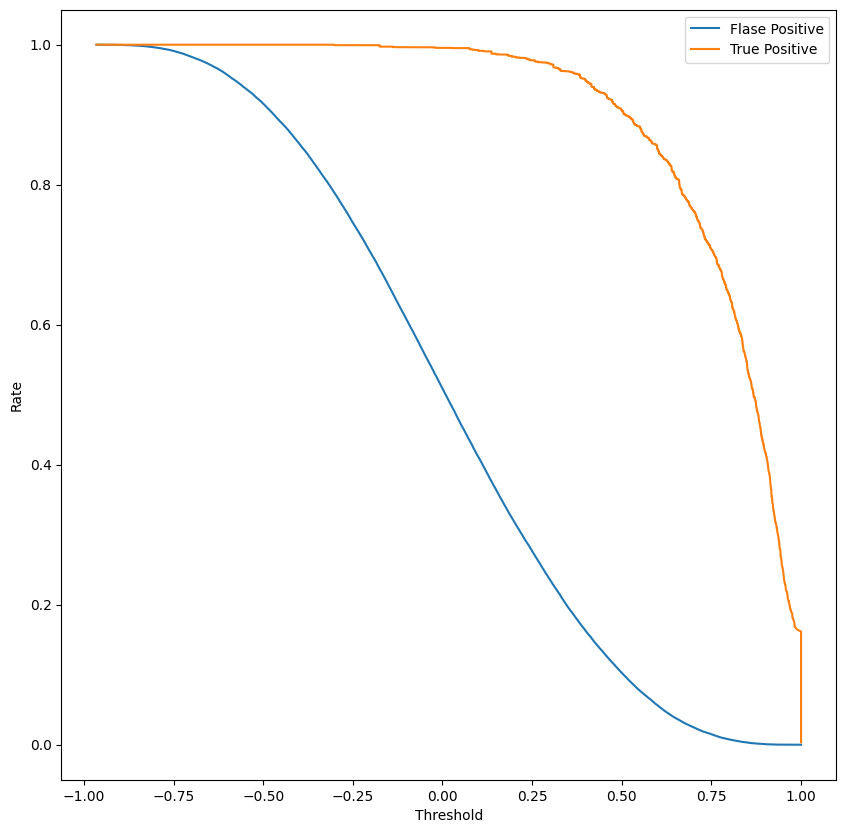

In [58]:
plt.subplots(1, figsize=(10,10))
plt.plot(threshold, false_positive_rate)
plt.plot(threshold, true_positive_rate)
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.legend(['Flase Positive', 'True Positive'])
plt.show()

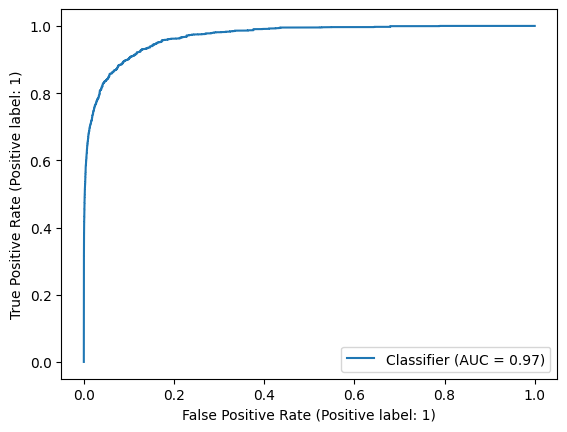

In [59]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(np.array(Y_true),np.array(cosine_sim))